# 1. Import Liberaries

In [ ]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import tensorflow as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing import image


# 2. Loading Data

In [6]:
train_directory = "Face Mask Dataset/Train"
validation_directory = "Face Mask Dataset/Validation"
test_directory = "Face Mask Dataset/Test"

IMG_SIZE = (128, 128)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

test_val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_directory,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

validation_generator = test_val_datagen.flow_from_directory(
    validation_directory,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = test_val_datagen.flow_from_directory(
    test_directory,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


# 3. Compare Augmentation

Found 10000 images belonging to 2 classes.


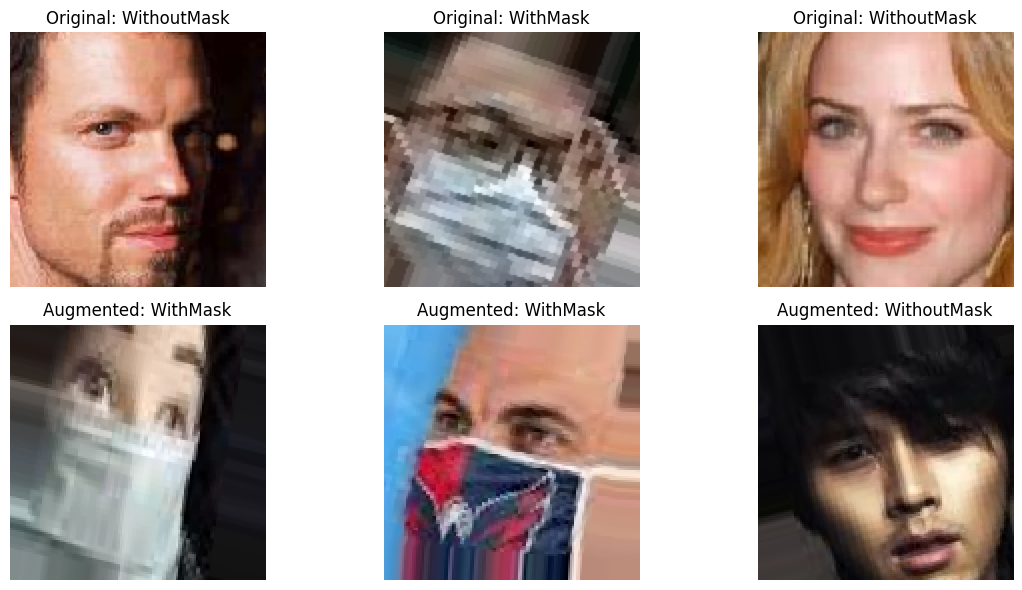

In [ ]:
no_aug_datagen = ImageDataGenerator(rescale=1./255)
no_aug_generator = no_aug_datagen.flow_from_directory(
    train_directory,
    target_size=IMG_SIZE,
    batch_size=8,
    class_mode='binary',
    shuffle=True
)


original_images, original_labels = next(no_aug_generator)
aug_images, aug_labels = next(train_generator)

n = 3
plt.figure(figsize=(12, 6))

for i in range(n):
    plt.subplot(2, n, i+1)
    plt.imshow(original_images[i])
    label = "WithMask" if original_labels[i] == 0 else "WithoutMask"
    plt.title(f"Original: {label}")
    plt.axis('off')

for i in range(n):
    plt.subplot(2, n, i+1+n)
    plt.imshow(aug_images[i])
    label = "WithMask" if aug_labels[i] == 0 else "WithoutMask"
    plt.title(f"Augmented: {label}")
    plt.axis('off')

plt.tight_layout()
plt.show()


# 4. Model Building

In [44]:
model = Sequential([
  Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
  MaxPooling2D(2,2),

  Conv2D(64, (3, 3), activation="relu"),
  MaxPooling2D(2,2),

  Conv2D(128, (3, 3), activation="relu"),
  MaxPooling2D(2,2),

  Flatten(),
  Dense(128, activation="relu"),
  Dropout(0.5),
  Dense(1, activation="sigmoid")
])


model.compile(
  optimizer=Adam(learning_rate=0.001),
  loss="binary_crossentropy",
  metrics=['accuracy']
)

model.summary()

c:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

# 5. Model Training


In [45]:
history = model.fit(
  train_generator,
  validation_data=validation_generator,
  epochs=10
)

c:\Users\User\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 160s 505ms/step - accuracy: 0.9391 - loss: 0.1700 - val_accuracy: 0.9737 - val_loss: 0.0606
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 118s 376ms/step - accuracy: 0.9611 - loss: 0.1175 - val_accuracy: 0.9787 - val_loss: 0.0585
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 119s 380ms/step - accuracy: 0.9707 - loss: 0.0857 - val_accuracy: 0.9887 - val_loss: 0.0291
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 111s 355ms/step - accuracy: 0.9753 - loss: 0.0670 - val_accuracy: 0.9912 - val_loss: 0.0244
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 109s 349ms/step - accuracy: 0.9797 - loss: 0.0639 - val_accuracy: 0.9875 - val_loss: 0.0297
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 125s 398ms/step - accuracy: 0.9803 - loss: 0.0539 - val_accuracy: 0.9850 - val_loss: 0.0401
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 129s 412ms/step - accuracy: 0.9813 - loss: 0.0574 - val_accuracy: 0.9925 - val_loss: 0.0207
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 124s 395ms/step - accuracy: 0.9838 -

# 6. Model Evaluation

In [46]:
loss, acc = model.evaluate(test_generator)
print(f"Test Accuracy: {acc*100:.2f}%")

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.9879 - loss: 0.0439
Test Accuracy: 98.79%


In [ ]:
y_pred_probs = model.predict(test_generator)
y_pred = (y_pred_probs > 0.5).astype(int)

y_true = test_generator.classes

class_labels = list(test_generator.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=class_labels))

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step
              precision    recall  f1-score   support

    WithMask       1.00      0.98      0.99       483
 WithoutMask       0.98      1.00      0.99       509

    accuracy                           0.99       992
   macro avg       0.99      0.99      0.99       992
weighted avg       0.99      0.99      0.99       992



In [ ]:
img_path = r"download1.jpeg"


img = image.load_img(img_path, target_size=IMG_SIZE)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

img_array = img_array / 255.0

prediction = model.predict(img_array)

if prediction[0][0] > 0.5:
    print("Without Mask")
else:
    print("With Mask")

print("Prediction score:", prediction[0][0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
✅ With Mask
Prediction score: 0.05046608


# 7. Model Saving

In [ ]:
model.save("mask_NN_model.h5")
